Loading and Cleaning Data
---

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd


In [2]:
data = []
with open("yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 100000:
            break
        data.append(json.loads(line))
df = pd.DataFrame(data) 


In [3]:
review_df = df[['stars', 'text']].astype({'stars': int})
review_df

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
...,...,...
99995,4,Came here for lunch with a group. They were bu...
99996,1,The equipment is so old and so felty! I just u...
99997,4,This is one of my favorite Mexican restaurants...
99998,2,Came here for brunch - had an omlette ($19 + t...


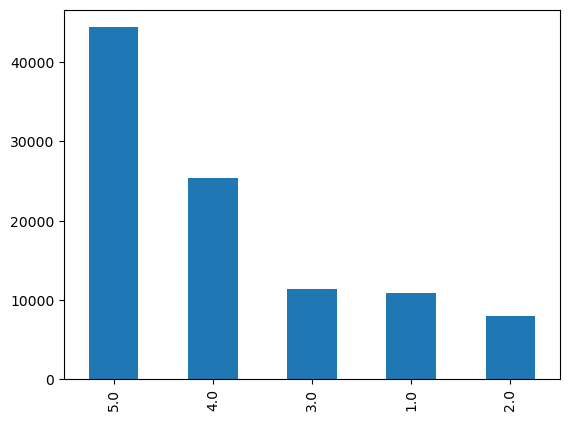

In [4]:
# inspect distribution of classes
df['stars'].value_counts().plot(kind='bar')
plt.show()

In [5]:
# randomly sample from each class based on how many samples the minority class holds
seed = 42
minority_class_count = len(review_df[review_df.loc[:, ('stars')] == 2])
review_df = review_df.groupby('stars').apply(lambda x: x.sample(n=minority_class_count, random_state=seed)).reset_index(drop=True)
review_df

,stars,text
0,1,"Spider, spider everywhere! Best for the Hallow..."
1,1,I bought a car here 12/31/14 and it will be th...
2,1,Apparently they feel free to charge people's b...
3,1,"They always get the order wrong, not sure if i..."
4,1,"Terrible! The place is a total mess, I'm surpr..."
...,...,...
39935,5,Had no idea the talent was this good! Awesome ...
39936,5,We are from out of town and stumbled upon this...
39937,5,Derrin and Sierra were AMAZING. We had a group...
39938,5,We were in Indianapolis on a business trip for...


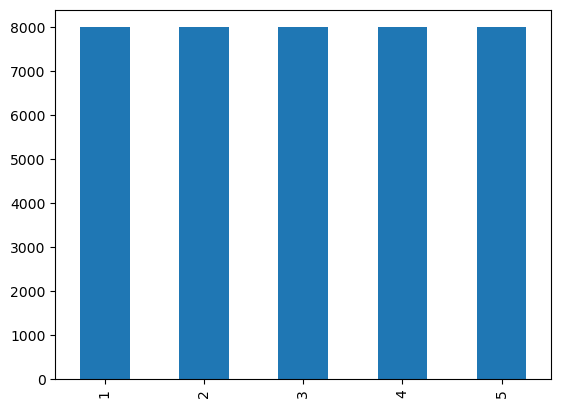

In [6]:
# inspect distribution of classes
review_df['stars'].value_counts().plot(kind='bar')
plt.show()

------------
Preproccess and transform data
---

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string

tweet_tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text preproccessing
def clean_text(text):
    text = text.lower()
    text = tweet_tokenizer.tokenize(text)
    text = [word for word in text if word not in string.punctuation]
    text = [word for word in text if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

all_tokens = [token for text in review_df['text'] for token in clean_text(text)]
print(f'vocab size: {len(set(all_tokens))}')


vocab size: 50890


In [8]:
# Get the frequencies of every word, sort and rank them by number of appearances
word_counts = Counter(all_tokens)
sorted_dict = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
ranked_dict = {word: rank for rank, (word, _) in enumerate(sorted_dict, start=1)}

# Use the ranking dictionary to encode the corpus and make it a numpy array
encoded_corpus = [[ranked_dict[token] for token in clean_text(text)] for text in review_df['text']]
encoded_corpus = np.array(encoded_corpus, dtype=object)
print(len(encoded_corpus), type(encoded_corpus))


39940 <class 'numpy.ndarray'>


In [9]:
# Creat list of labels
labels = [star for star in review_df['stars']]
labels = np.array(labels, dtype=np.int64)


In [10]:
from sklearn.model_selection import train_test_split

# Split into training and validation
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    encoded_corpus, labels, test_size=0.2, random_state=42
)
print(f'Training length: {len(train_reviews)}, validation length: {len(val_reviews)}')


Training length: 31952, validation length: 7988


In [11]:
# truncate and pad input sequences
max_review_length = 150
train_reviews = sequence.pad_sequences(train_reviews, maxlen=max_review_length)
val_reviews = sequence.pad_sequences(val_reviews, maxlen=max_review_length)

# covert labels to one_hot encoded labels
train_labels_one_hot = to_categorical(train_labels - 1, 5)
val_labels_one_hot = to_categorical(val_labels - 1, 5)


------
Models
----

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
import keras
import pickle
import seaborn as sns


'''Save model and its weights'''
def save_model(model, path):
    model.save(f'{path}.keras')
    model.save_weights(f'{path}_weights.keras')
    
'''Load model and its weights'''
def load_model(path):
    model = keras.models.load_model(f'{path}.keras')
    model.load_weights(f'{path}_weights.keras')
    return model

'''Save model history'''
def save_model_history(model_history, path):
    with open(f'{path}.pkl', 'wb') as file:
        pickle.dump(model_history, file)

'''Load model history'''
def load_model_history(path):
    with open(f'{path}.pkl', 'rb') as file:
        return pickle.load(file)

'''Find accuracy of predictions with a tolerance of 1 star'''
def evaluate_accuracy_with_tolerance(y_true, y_pred, tolerance=1):
    correct_predictions = 0
    for true, pred in zip(y_true, y_pred):
        if np.abs(np.argmax(true) - pred) <= tolerance:
            correct_predictions += 1

    accuracy = correct_predictions / len(y_true) * 100
    return accuracy


def evaluate_model(model, val_reviews, val_labels_one_hot, model_history):
    ''' 
    Evaluates the model with accuracy, accuracy within 1 star, 
    and with a 5x5 confusion matrix.
    '''
    
    # Calculate predicted labels with validation reviews
    predicted_probabilities = model.predict(val_reviews)
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
    # Prints the exact accuracy of the model
    scores = model.evaluate(val_reviews, val_labels_one_hot, verbose=0)
    print("Exact accuracy: %.2f%%" % (scores[1]*100))

    # Calculate accuracy of model within 1 star
    accuracy_with_tolerance = evaluate_accuracy_with_tolerance(val_labels_one_hot, predicted_labels, 1)
    print(f"Accuracy within 1 star: {accuracy_with_tolerance:.2f}%")

    plt.plot(model_history.history['accuracy'], label='Training Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    # Diplay evaluation results in a 5x5 confusion matrix
    cm = confusion_matrix(np.argmax(val_labels_one_hot, axis=1), predicted_labels)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    

------
RNN model

In [23]:
from tensorflow.keras.layers import SimpleRNN

rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_review_length))
rnn_model.add(SimpleRNN(80))
rnn_model.add(Dense(5, activation='softmax'))
rnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 64)           145671424 
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 80)                11600     
                                                                 
 dense_4 (Dense)             (None, 5)                 405       
                                                                 
Total params: 145683429 (555.74 MB)
Trainable params: 145683429 (555.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Train model
rnn_history = rnn_model.fit(
    train_reviews, train_labels_one_hot, epochs=2, batch_size=64,
    validation_data=(val_reviews, val_labels_one_hot))

Epoch 1/2
500/500 [==============================] - 966s 2s/step - loss: 1.3626 - accuracy: 0.3689 - val_loss: 1.1308 - val_accuracy: 0.4975
Epoch 2/2
500/500 [==============================] - 974s 2s/step - loss: 0.9066 - accuracy: 0.6292 - val_loss: 1.1359 - val_accuracy: 0.5016


In [26]:
# Save model architecture and weights
save_model(rnn_model, 'rnn_model')
save_model_history(rnn_history, 'rnn_history')

In [28]:
# Load model architecture and weights
rnn_model = load_model('rnn_model')
rnn_history = load_model_history('rnn_history')

250/250 [==============================] - 6s 21ms/step
Exact accuracy: 50.16%
Accuracy within 1 star: 89.18%


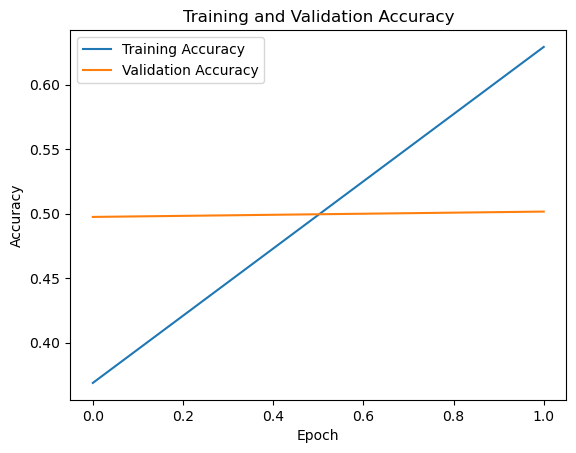

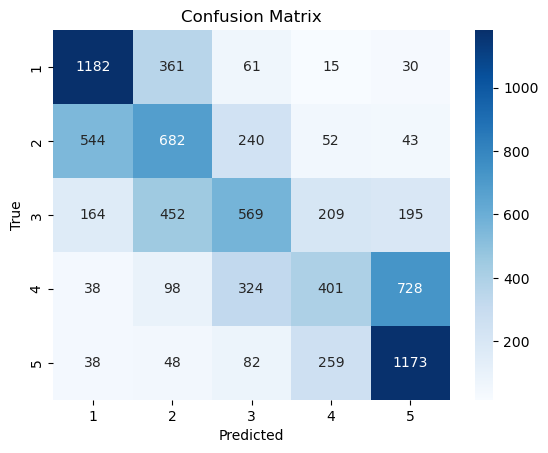

In [25]:
# evaluation of the model
evaluate_model(rnn_model, val_reviews, val_labels_one_hot, rnn_history)


------
LSTM Model


In [29]:
from tensorflow.keras.layers import LSTM

# Initialize hyperparameters
embedding_dim = 64
vocab_size = len(all_tokens) + 1
lr = 0.0005

# Initialize model
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_review_length))
lstm_model.add(LSTM(80))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 64)           145671424 
                                                                 
 lstm_3 (LSTM)               (None, 80)                46400     
                                                                 
 dense_5 (Dense)             (None, 5)                 405       
                                                                 
Total params: 145718229 (555.87 MB)
Trainable params: 145718229 (555.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [30]:
# Train model
lstm_history = lstm_model.fit(
    train_reviews, train_labels_one_hot, epochs=2, batch_size=64, 
    validation_data=(val_reviews, val_labels_one_hot))


Epoch 1/2
500/500 [==============================] - 791s 2s/step - loss: 1.2037 - accuracy: 0.4540 - val_loss: 1.0061 - val_accuracy: 0.5586
Epoch 2/2
500/500 [==============================] - 749s 1s/step - loss: 0.8977 - accuracy: 0.6148 - val_loss: 0.9930 - val_accuracy: 0.5671


In [31]:
# Save model architecture and weights
save_model(lstm_model, 'lstm_model')
save_model_history(lstm_history, 'lstm_history')

In [32]:
# Load model architecture and weights
lstm_model = load_model('lstm_model')
lstm_history = load_model_history('lstm_history')

250/250 [==============================] - 10s 37ms/step
Exact accuracy: 56.71%
Accuracy within 1 star: 93.77%


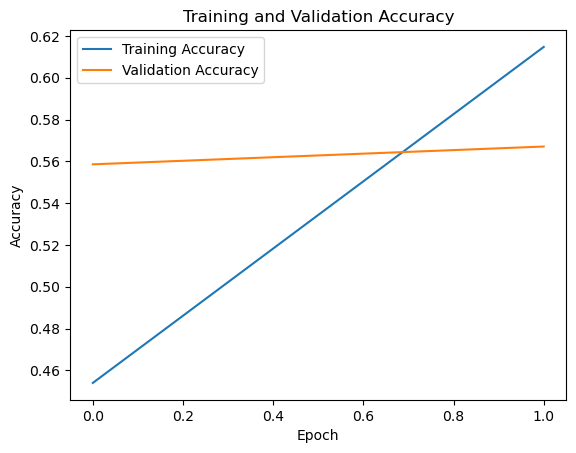

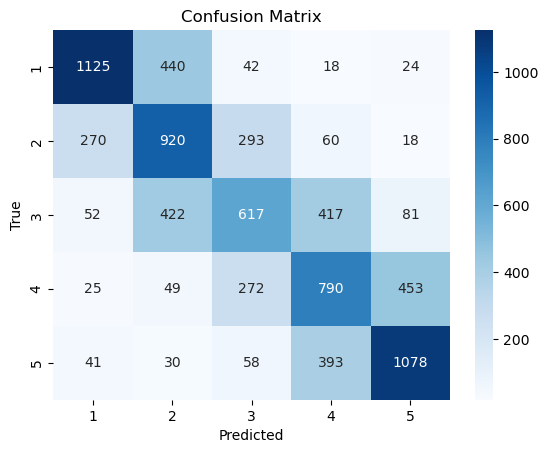

In [33]:
# evaluation of the model
evaluate_model(lstm_model, val_reviews, val_labels_one_hot, lstm_history)


------
CNN Model

In [73]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

# Initialize hyperparameters
embedding_dim = 64
vocab_size = len(all_tokens) + 1
lr = 0.0005

# Initialize model
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_review_length))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

print(cnn_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 64)           145671424 
                                                                 
 conv1d_2 (Conv1D)           (None, 146, 128)          41088     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 73, 128)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9344)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 46725     
                                                                 
Total params: 145759237 (556.03 MB)
Trainable params: 145759237 (556.03 MB)
Non-trainable params: 0 (0.00 Byte)
________

In [74]:
# Train model
cnn_history = cnn_model.fit(
    train_reviews, train_labels_one_hot, epochs=2, batch_size=64, 
    validation_data=(val_reviews, val_labels_one_hot))


Epoch 1/3
500/500 [==============================] - 623s 1s/step - loss: 1.2332 - accuracy: 0.4390 - val_loss: 0.9971 - val_accuracy: 0.5657
Epoch 2/3
500/500 [==============================] - 540s 1s/step - loss: 0.8788 - accuracy: 0.6245 - val_loss: 1.0015 - val_accuracy: 0.5707
Epoch 3/3
500/500 [==============================] - 542s 1s/step - loss: 0.7196 - accuracy: 0.7058 - val_loss: 1.0811 - val_accuracy: 0.5583


In [75]:
# Save model architecture and weights
save_model(cnn_model, 'cnn_model')
save_model_history(cnn_history, 'cnn_history')

In [20]:
# Load model architecture and weights
cnn_model = load_model('cnn_model')
cnn_history = load_model_history('cnn_history')

250/250 [==============================] - 2s 7ms/step
Exact accuracy: 55.83%
Accuracy within 1 star: 92.88%


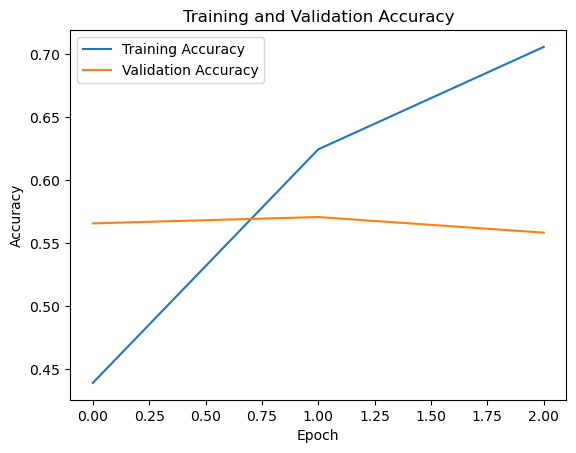

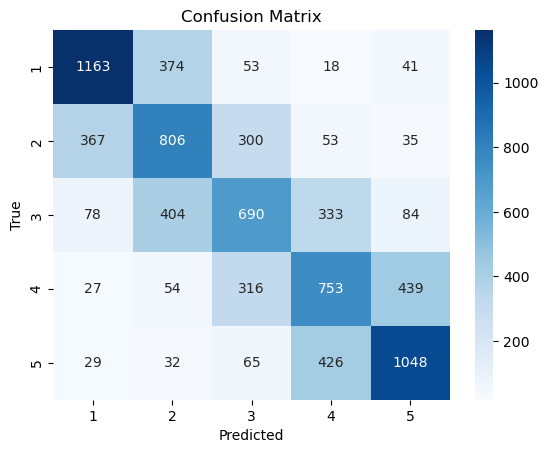

In [21]:
# evaluation of the model
evaluate_model(cnn_model, val_reviews, val_labels_one_hot, cnn_history)


------
GRU Model

In [78]:
from keras.layers import Embedding, GRU, Dense

# Initialize hyperparameters
embedding_dim = 64
vocab_size = len(all_tokens) + 1
lr = 0.0005

# Initialize model
gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_review_length))
gru_model.add(GRU(units=80))
gru_model.add(Dense(units=5, activation='softmax'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(gru_model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 64)           145671424 
                                                                 
 gru_1 (GRU)                 (None, 80)                35040     
                                                                 
 dense_6 (Dense)             (None, 5)                 405       
                                                                 
Total params: 145706869 (555.83 MB)
Trainable params: 145706869 (555.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [79]:
# Train model
gru_history = gru_model.fit(train_reviews, train_labels_one_hot, epochs=3, batch_size=64, validation_data=(val_reviews, val_labels_one_hot))

Epoch 1/3
500/500 [==============================] - 592s 1s/step - loss: 1.1913 - accuracy: 0.4549 - val_loss: 0.9973 - val_accuracy: 0.5669
Epoch 2/3
500/500 [==============================] - 642s 1s/step - loss: 0.8585 - accuracy: 0.6294 - val_loss: 1.0061 - val_accuracy: 0.5638
Epoch 3/3
500/500 [==============================] - 5284s 11s/step - loss: 0.6937 - accuracy: 0.7185 - val_loss: 1.0799 - val_accuracy: 0.5602


In [80]:
# Save model architecture, weights, and history
save_model(gru_model, 'gru_model')
save_model_history(gru_history, 'gru_history')

In [22]:
# Load model architecture, weights, and history
gru_model = load_model('gru_model')
gru_history = load_model_history('gru_history')

250/250 [==============================] - 5s 20ms/step
Exact accuracy: 56.02%
Accuracy within 1 star: 92.96%


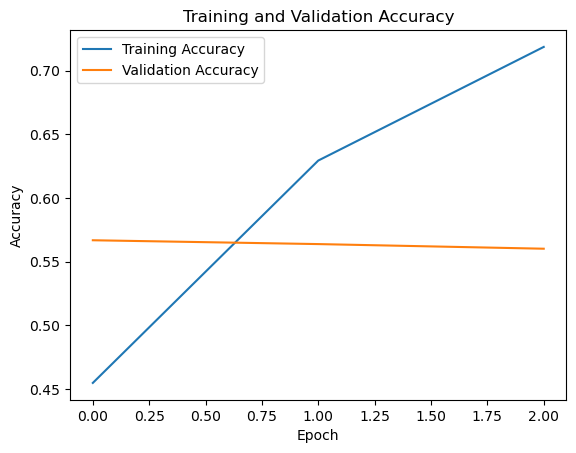

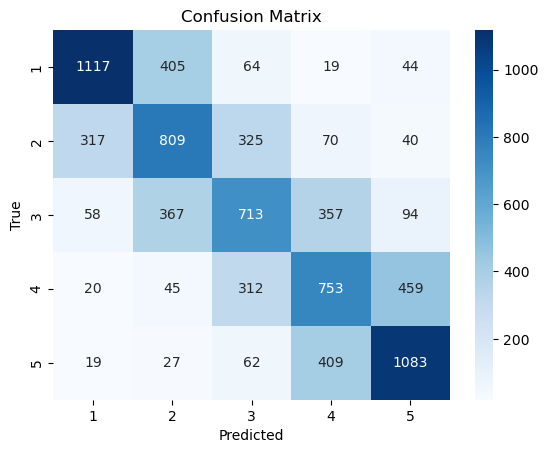

In [23]:
# evaluation of the model
evaluate_model(gru_model, val_reviews, val_labels_one_hot, gru_history)
